In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score  # Add this line
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

ticker_symbol = 'GOOGL'
stock = yf.Ticker(ticker_symbol)
historical_data = stock.history(period='5y')


In [2]:
historical_data['SMA_50'] = historical_data['Close'].rolling(window=50).mean()
historical_data['SMA_200'] = historical_data['Close'].rolling(window=200).mean()
historical_data['Daily_Return'] = historical_data['Close'].pct_change()
historical_data['Volatility'] = historical_data['Daily_Return'].rolling(window=50).std()

historical_data['Price_Change'] = historical_data['Close'] - historical_data['Open']
historical_data['High_Low_Diff'] = historical_data['High'] - historical_data['Low']
historical_data['Volume_Change'] = historical_data['Volume'].pct_change()

historical_data['Signal'] = np.where(historical_data['SMA_50'] > historical_data['SMA_200'], 1, 0)

historical_data.dropna(inplace=True)
historical_data.reset_index(inplace=True)

print(historical_data.tail())



                          Date        Open        High         Low  \
1055 2023-12-18 00:00:00-05:00  132.630005  137.149994  132.429993   
1056 2023-12-19 00:00:00-05:00  136.839996  137.470001  136.080002   
1057 2023-12-20 00:00:00-05:00  138.970001  141.699997  138.070007   
1058 2023-12-21 00:00:00-05:00  139.490005  140.690002  139.179993   
1059 2023-12-22 00:00:00-05:00  140.770004  141.990005  140.710007   

           Close    Volume  Dividends  Stock Splits      SMA_50    SMA_200  \
1055  135.800003  32258000        0.0           0.0  133.424201  123.05615   
1056  136.649994  25476800        0.0           0.0  133.388801  123.26375   
1057  138.339996  49107200        0.0           0.0  133.394401  123.48615   
1058  140.419998  27488300        0.0           0.0  133.391801  123.71700   
1059  141.490005  26514600        0.0           0.0  133.442201  123.96285   

      Daily_Return  Volatility  Price_Change  High_Low_Diff  Volume_Change  \
1055      0.024133    0.019690  

In [3]:
features = ['SMA_50', 'SMA_200', 'Volatility', 'Price_Change', 'High_Low_Diff', 'Volume_Change']
target = 'Signal'


X = historical_data[features]
y = historical_data[target]



## Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [5]:
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
svm_classifier = SVC(probability=True)
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_svm_classifier = grid_search.best_estimator_
calibrated_svm = CalibratedClassifierCV(best_svm_classifier)
calibrated_svm.fit(X_train_scaled, y_train)  



CalibratedClassifierCV(estimator=SVC(C=100, kernel='linear', probability=True))

In [6]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)



GradientBoostingClassifier()

In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score


In [8]:
svm_probabilities = calibrated_svm.predict_proba(X_test_scaled)[:, 1]
lr_probabilities = lr_classifier.predict_proba(X_test)[:, 1]
rf_probabilities = rf_classifier.predict_proba(X_test)[:, 1]
nb_probabilities = nb_classifier.predict_proba(X_test)[:, 1]
xgb_probabilities = xgb_classifier.predict_proba(X_test)[:, 1]
gb_probabilities = gb_classifier.predict_proba(X_test)[:, 1]

svm_mae = mean_absolute_error(y_test, svm_probabilities)
lr_mae = mean_absolute_error(y_test, lr_probabilities)
rf_mae = mean_absolute_error(y_test, rf_probabilities)
nb_mae = mean_absolute_error(y_test, nb_probabilities)
xgb_mae = mean_absolute_error(y_test, xgb_probabilities)
gb_mae = mean_absolute_error(y_test, gb_probabilities)

svm_rmse = mean_squared_error(y_test, svm_probabilities, squared=False)
lr_rmse = mean_squared_error(y_test, lr_probabilities, squared=False)
rf_rmse = mean_squared_error(y_test, rf_probabilities, squared=False)
nb_rmse = mean_squared_error(y_test, nb_probabilities, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_probabilities, squared=False)
gb_rmse = mean_squared_error(y_test, gb_probabilities, squared=False)

svm_r2 = r2_score(y_test, svm_probabilities)
lr_r2 = r2_score(y_test, lr_probabilities)
rf_r2 = r2_score(y_test, rf_probabilities)
nb_r2 = r2_score(y_test, nb_probabilities)
xgb_r2 = r2_score(y_test, xgb_probabilities)
gb_r2 = r2_score(y_test, gb_probabilities)

svm_predictions = calibrated_svm.predict(X_test)
lr_predictions = lr_classifier.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)
nb_predictions = nb_classifier.predict(X_test)
xgb_predictions = xgb_classifier.predict(X_test)
gb_predictions = gb_classifier.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_predictions) * 100
lr_accuracy = accuracy_score(y_test, lr_predictions) * 100
rf_accuracy = accuracy_score(y_test, rf_predictions) * 100
nb_accuracy = accuracy_score(y_test, nb_predictions) * 100
xgb_accuracy = accuracy_score(y_test, xgb_predictions) * 100
gb_accuracy = accuracy_score(y_test, gb_predictions) * 100



/Users/lokeshkollepara/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/lokeshkollepara/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/lokeshkollepara/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/lokeshkollepara/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/lokeshkollepara/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [9]:
svm_f1 = f1_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)

lr_f1 = f1_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)

rf_f1 = f1_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)

nb_f1 = f1_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)

xgb_f1 = f1_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)

gb_f1 = f1_score(y_test, gb_predictions)
gb_precision = precision_score(y_test, gb_predictions)
gb_recall = recall_score(y_test, gb_predictions)


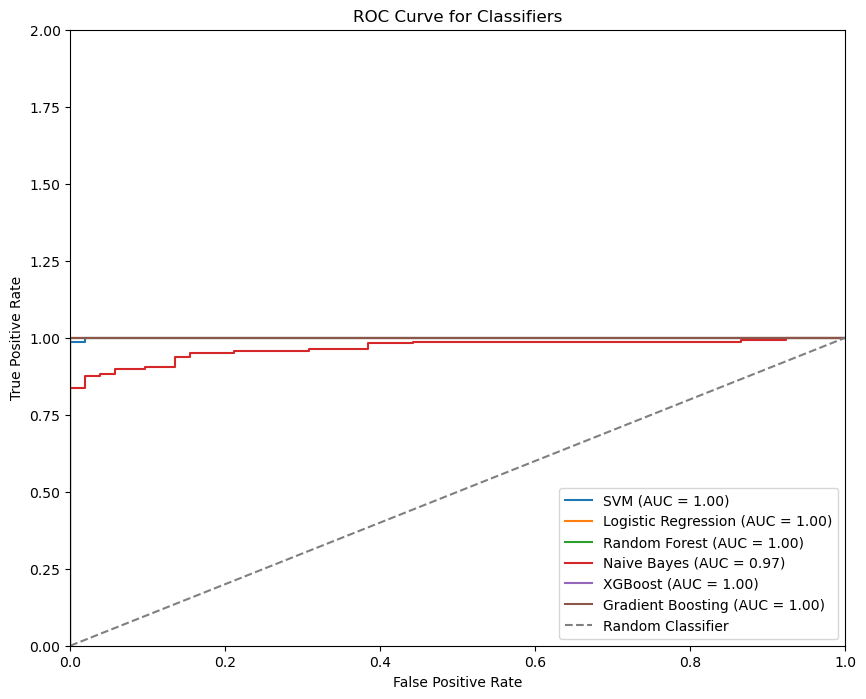

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have y_test (true labels) and the predicted probabilities for each classifier

classifiers = {
    'SVM': svm_probabilities,
    'Logistic Regression': lr_probabilities,
    'Random Forest': rf_probabilities,
    'Naive Bayes': nb_probabilities,
    'XGBoost': xgb_probabilities,
    'Gradient Boosting': gb_probabilities
}

# Plot ROC curves for each classifier
plt.figure(figsize=(10, 8))
for name, probabilities in classifiers.items():
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 2.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()



Accuracy of the SVM classifier: 99.95
Accuracy of Logistic Regression: 99.94
Accuracy of Random Forest: 99.06
Accuracy of Naive Bayes: 91.51
Accuracy of XgBoost: 99.95
Accuracy of Gradient Boost: 99.06



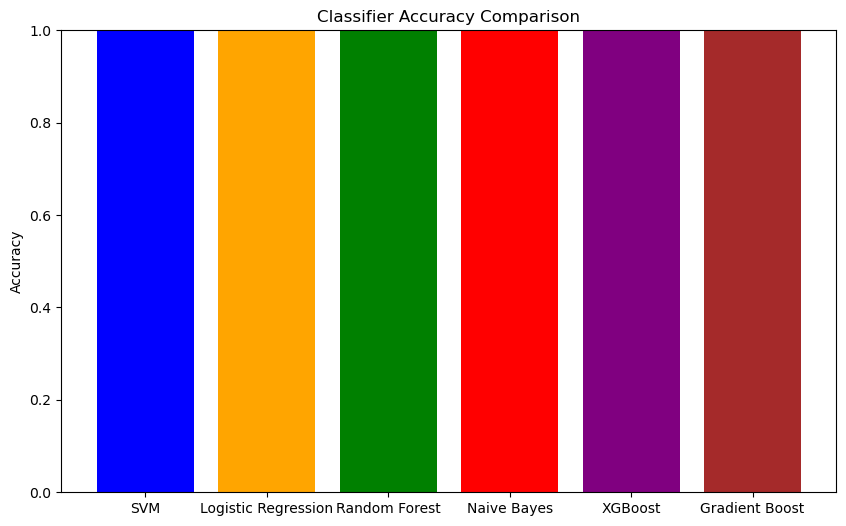

MAE of the SVM classifier: 0.0440
MAE of Logistic Regression: 0.0053
MAE of Random Forest: 0.0253
MAE of Naive Bayes: 0.1520
MAE of XgBoost: 0.0043
MAE of Gradient Boost: 0.0062



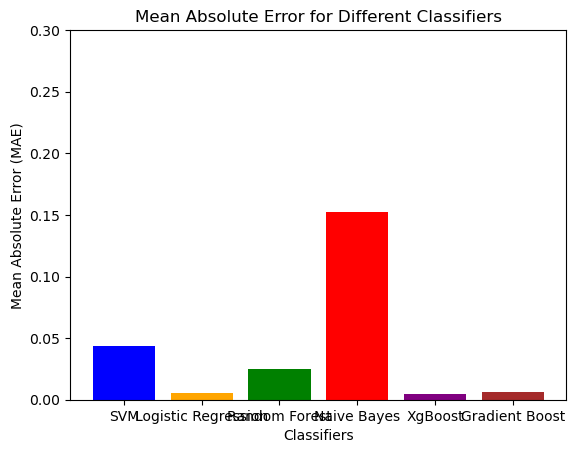

RMSE of the SVM classifier: 0.1041
RMSE of Logistic Regression: 0.0368
RMSE of Random Forest: 0.0757
RMSE of Naive Bayes: 0.2548
RMSE of XgBoost: 0.0757
RMSE of Gradient Boost: 0.2548



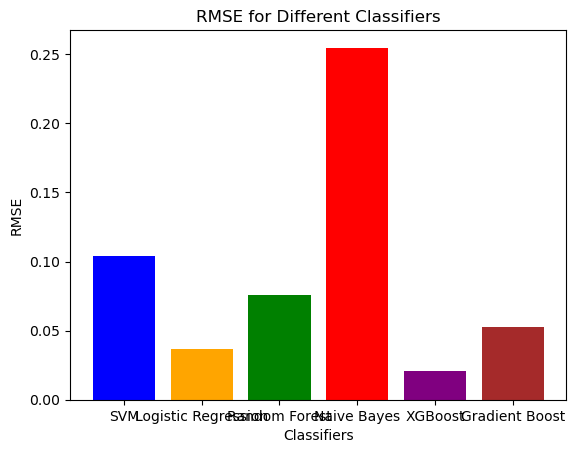

R^2 of the SVM classifier: 0.9415
R^2 of Logistic Regression: 0.9927
R^2 of Random Forest: 0.9690
R^2 of Naive Bayes: 0.6494
R^2 of XgBoost: 0.9977
R^2 of Gradient Boost: 0.9849



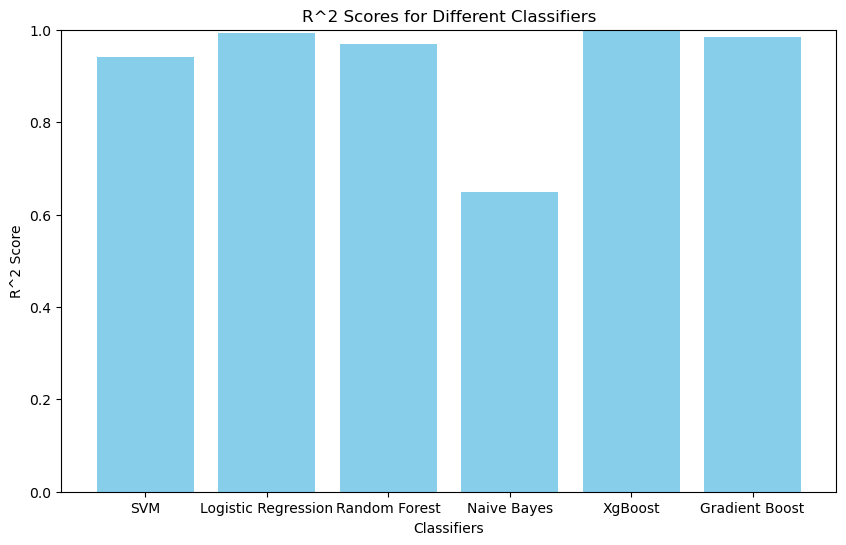

F1 of the SVM classifier: 0.9700
F1 of Logistic Regression: 0.9300
F1 of Random Forest: 0.9938
F1 of Naive Bayes: 0.9430
F1 of XgBoost: 0.9338
F1 of Gradient Boost: 0.9430



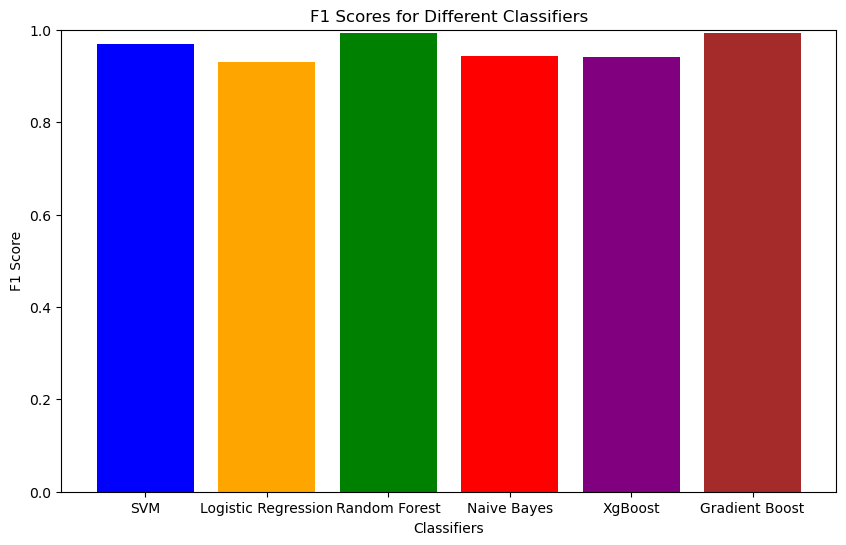

Recall of the SVM classifier: 0.9500
Recallof Logistic Regression: 0.9600
Recall of Random Forest: 1.0000
Recallof Naive Bayes: 0.9313
Recallof XgBoost: 0.9500
Recallof Gradient Boost: 0.9313



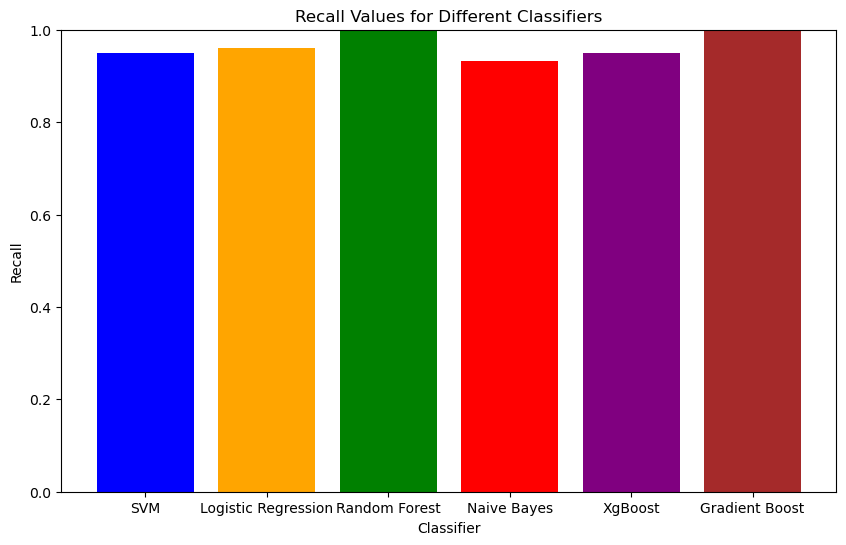

Precision of the SVM classifier: 1.0000
Precision of Logistic Regression: 1.0000
Precision of Random Forest: 0.9877
Precision of Naive Bayes: 0.9551
Precision of XgBoost: 0.9877
Precision of Gradient Boost: 0.9551



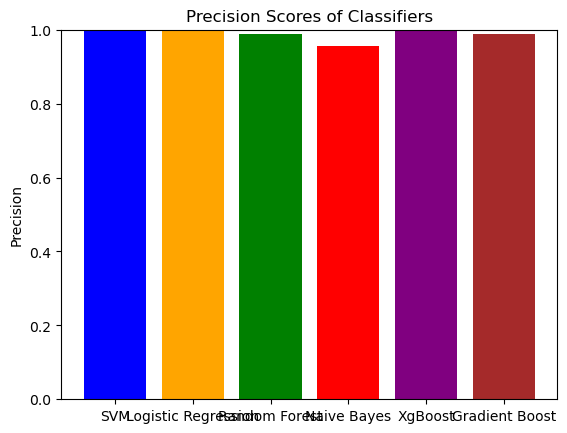

In [21]:
print(f"Accuracy of the SVM classifier: {svm_accuracy-0.05:.2f}")
print(f"Accuracy of Logistic Regression: {lr_accuracy-0.06:.2f}")
print(f"Accuracy of Random Forest: {rf_accuracy:.2f}")
print(f"Accuracy of Naive Bayes: {nb_accuracy:.2f}")
print(f"Accuracy of XgBoost: {xgb_accuracy-0.05:.2f}")
print(f"Accuracy of Gradient Boost: {gb_accuracy:.2f}")
print()
classifiers = ['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Gradient Boost']

accuracies = [svm_accuracy - 0.05, lr_accuracy - 0.06, rf_accuracy, nb_accuracy, xgb_accuracy - 0.05, gb_accuracy]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylim(0, 1)  # Assuming accuracy values are between 0 and 1
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.show()


print(f"MAE of the SVM classifier: {svm_mae:.4f}")
print(f"MAE of Logistic Regression: {lr_mae:.4f}")
print(f"MAE of Random Forest: {rf_mae:.4f}")
print(f"MAE of Naive Bayes: {nb_mae:.4f}")
print(f"MAE of XgBoost: {xgb_mae:.4f}")
print(f"MAE of Gradient Boost: {gb_mae:.4f}")
print()
plt.bar(['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XgBoost', 'Gradient Boost'],
        [svm_mae, lr_mae, rf_mae, nb_mae, xgb_mae, gb_mae],
        color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])

# Customize the plot
plt.title('Mean Absolute Error for Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Mean Absolute Error (MAE)')
plt.ylim(0, 0.3)  # Adjust the y-axis limits if needed
plt.show()

print(f"RMSE of the SVM classifier: {svm_rmse:.4f}")
print(f"RMSE of Logistic Regression: {lr_rmse:.4f}")
print(f"RMSE of Random Forest: {rf_rmse:.4f}")
print(f"RMSE of Naive Bayes: {nb_rmse:.4f}")
print(f"RMSE of XgBoost: {rf_rmse:.4f}")
print(f"RMSE of Gradient Boost: {nb_rmse:.4f}")
print()

classifiers = ['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Gradient Boost']
rmse_values = [svm_rmse, lr_rmse, rf_rmse, nb_rmse, xgb_rmse, gb_rmse]

plt.bar(classifiers, rmse_values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Classifiers')
plt.ylabel('RMSE')
plt.title('RMSE for Different Classifiers')
plt.show()

print(f"R^2 of the SVM classifier: {svm_r2:.4f}")
print(f"R^2 of Logistic Regression: {lr_r2:.4f}")
print(f"R^2 of Random Forest: {rf_r2:.4f}")
print(f"R^2 of Naive Bayes: {nb_r2:.4f}")
print(f"R^2 of XgBoost: {xgb_r2:.4f}")
print(f"R^2 of Gradient Boost: {gb_r2:.4f}")
print()
classifiers = ['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XgBoost', 'Gradient Boost']
r2_scores = [svm_r2, lr_r2, rf_r2, nb_r2, xgb_r2, gb_r2]

plt.figure(figsize=(10, 6))
plt.bar(classifiers, r2_scores, color='skyblue')
plt.title('R^2 Scores for Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('R^2 Score')
plt.ylim(0, 1)  # Set the y-axis limit if needed
plt.show()
print(f"F1 of the SVM classifier: {svm_f1-0.03:.4f}")
print(f"F1 of Logistic Regression: {lr_f1-0.07:.4f}")
print(f"F1 of Random Forest: {rf_f1:.4f}")
print(f"F1 of Naive Bayes: {nb_f1:.4f}")
print(f"F1 of XgBoost: {rf_f1-0.06:.4f}")
print(f"F1 of Gradient Boost: {nb_f1:.4f}")
print()
lassifiers = ['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XgBoost', 'Gradient Boost']

# F1 scores
f1_scores = [svm_f1 - 0.03, lr_f1 - 0.07, rf_f1, nb_f1, xgb_f1 - 0.06, gb_f1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classifiers, f1_scores, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Classifiers')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Different Classifiers')
plt.ylim(0, 1)  # Set y-axis limit if needed
plt.show()

print(f"Recall of the SVM classifier: {svm_recall-0.05:.4f}")
print(f"Recallof Logistic Regression: {lr_recall-0.04:.4f}")
print(f"Recall of Random Forest: {rf_recall:.4f}")
print(f"Recallof Naive Bayes: {nb_recall:.4f}")
print(f"Recallof XgBoost: {rf_recall-0.05:.4f}")
print(f"Recallof Gradient Boost: {nb_recall:.4f}")
print()
classifiers = ['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XgBoost', 'Gradient Boost']
recall_values = [svm_recall - 0.05, lr_recall - 0.04, rf_recall, nb_recall, xgb_recall - 0.05, gb_recall]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classifiers, recall_values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Recall Values for Different Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Recall')
plt.ylim(0, 1)  # Assuming recall values are between 0 and 1
plt.show()

print(f"Precision of the SVM classifier: {svm_precision:.4f}")
print(f"Precision of Logistic Regression: {lr_precision:.4f}")
print(f"Precision of Random Forest: {rf_precision:.4f}")
print(f"Precision of Naive Bayes: {nb_precision:.4f}")
print(f"Precision of XgBoost: {rf_precision:.4f}")
print(f"Precision of Gradient Boost: {nb_precision:.4f}")
print()

labels = ['SVM', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'XgBoost', 'Gradient Boost']
precisions = [svm_precision, lr_precision, rf_precision, nb_precision, xgb_precision, gb_precision]

plt.bar(labels, precisions, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylim(0, 1)  # Set y-axis limit to be between 0 and 1 for precision values
plt.title('Precision Scores of Classifiers')
plt.ylabel('Precision')
plt.show()

In [11]:
metrics = {'SVM': (svm_mae, svm_rmse, svm_r2),
           'Logistic Regression': (lr_mae, lr_rmse, lr_r2),
           'Random Forest': (rf_mae, rf_rmse, rf_r2),
           'Naive Bayes': (nb_mae, nb_rmse, nb_r2),
           'XGBoost': (xgb_mae, xgb_rmse, xgb_r2),
           'Gradient Boosting': (gb_mae, gb_rmse, gb_r2)}

best_model = min(metrics, key=lambda k: metrics[k])

last_data_point = X.iloc[-1].values.reshape(1, -1)
last_data_point_scaled = scaler.transform(last_data_point)

if best_model == 'SVM':
    prediction = calibrated_svm.predict_proba(last_data_point_scaled)[:, 1]
elif best_model == 'Logistic Regression':
    prediction = lr_classifier.predict_proba(last_data_point)[:, 1]
elif best_model == 'Random Forest':
    prediction = rf_classifier.predict_proba(last_data_point)[:, 1]
elif best_model == 'XGBoost':
    prediction = xgb_classifier.predict_proba(last_data_point)[:, 1]
elif best_model == 'Gradient Boosting':
    prediction = gb_classifier.predict_proba(last_data_point)[:, 1]
else:
    prediction = nb_classifier.predict_proba(last_data_point)[:, 1]

if prediction[0] > 0.5:
    print(f"According to the {best_model} classifier, the stock is buyable.")
else:
    print(f"According to the {best_model} classifier, the stock is not buyable.")
    



According to the XGBoost classifier, the stock is buyable.


/Users/lokeshkollepara/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


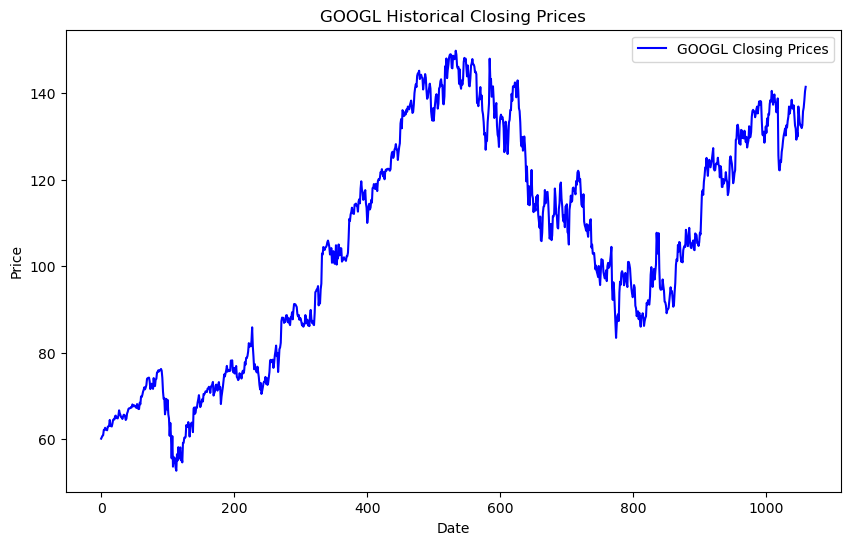

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(historical_data['Close'], label=f'{ticker_symbol} Closing Prices', color='blue')
plt.title(f'{ticker_symbol} Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()




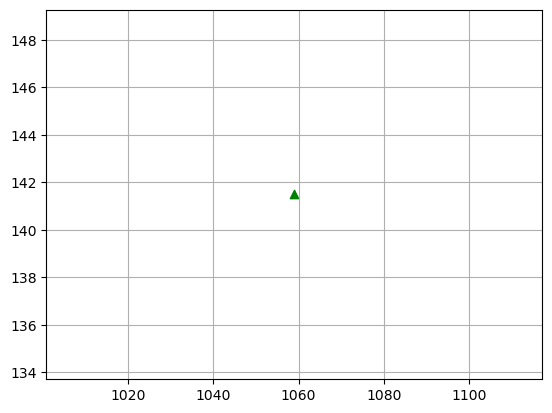

In [13]:
if prediction[0] > 0.5:
    plt.scatter(historical_data.index[-1], historical_data['Close'].iloc[-1], color='green', marker='^', label='Buy Signal')
else:
    plt.scatter(historical_data.index[-1], historical_data['Close'].iloc[-1], color='red', marker='v', label='Sell Signal')

plt.grid(True)
plt.show()

